In [0]:
from __future__ import  absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt

Keras = tf.keras

TensorFlow 2.x selected.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Loading Data
import pandas as pd
#!ls /content/drive/'My Drive'/'Colab Notebooks'
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Term_project_simulation/selected_data_ISONE.csv')
data.head()

date  year  month  day  weekday  hour   demand  temperature
0  2003/3/1  2003      3    1        7     1  12863.0           23
1  2003/3/1  2003      3    1        7     2  12389.0           22
2  2003/3/1  2003      3    1        7     3  12155.0           21
3  2003/3/1  2003      3    1        7     4  12072.0           21
4  2003/3/1  2003      3    1        7     5  12160.0           22

In [0]:
data['load'] = data['demand']/data['demand'].values.max()
data.head()

date  year  month  day  weekday  hour   demand  temperature      load
0  2003/3/1  2003      3    1        7     1  12863.0           23  0.465680
1  2003/3/1  2003      3    1        7     2  12389.0           22  0.448519
2  2003/3/1  2003      3    1        7     3  12155.0           21  0.440048
3  2003/3/1  2003      3    1        7     4  12072.0           21  0.437043
4  2003/3/1  2003      3    1        7     5  12160.0           22  0.440229

In [0]:
# Series Plot

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [0]:
data = data.set_index("date")
data.head()

year  month  day  weekday  hour   demand  temperature      load
date                                                                     
2003/3/1  2003      3    1        7     1  12863.0           23  0.465680
2003/3/1  2003      3    1        7     2  12389.0           22  0.448519
2003/3/1  2003      3    1        7     3  12155.0           21  0.440048
2003/3/1  2003      3    1        7     4  12072.0           21  0.437043
2003/3/1  2003      3    1        7     5  12160.0           22  0.440229

In [0]:
series = data.loc[:'2006/12/31']
series.head()

year  month  day  weekday  hour   demand  temperature      load
date                                                                     
2003/3/1  2003      3    1        7     1  12863.0           23  0.465680
2003/3/1  2003      3    1        7     2  12389.0           22  0.448519
2003/3/1  2003      3    1        7     3  12155.0           21  0.440048
2003/3/1  2003      3    1        7     4  12072.0           21  0.437043
2003/3/1  2003      3    1        7     5  12160.0           22  0.440229

In [0]:
series.tail()

year  month  day  weekday  hour   demand  temperature      load
date                                                                       
2006/12/31  2006     12   31        1    20  16400.0           30  0.593730
2006/12/31  2006     12   31        1    21  15742.0           31  0.569908
2006/12/31  2006     12   31        1    22  15020.0           30  0.543769
2006/12/31  2006     12   31        1    23  14233.0           29  0.515278
2006/12/31  2006     12   31        1    24  13442.0           29  0.486641

In [0]:
train_series = series.loc[:'2005/12/31']
train_series.tail()

year  month  day  weekday  hour   demand  temperature      load
date                                                                       
2005/12/31  2005     12   31        7    20  17052.0           26  0.617334
2005/12/31  2005     12   31        7    21  16334.0           29  0.591340
2005/12/31  2005     12   31        7    22  15564.0           29  0.563464
2005/12/31  2005     12   31        7    23  14804.0           29  0.535950
2005/12/31  2005     12   31        7    24  14000.0           29  0.506842

In [0]:
valid_series = series.loc['2006/1/1':]
valid_series.tail(2)

year  month  day  weekday  hour   demand  temperature      load
date                                                                       
2006/12/31  2006     12   31        1    23  14233.0           29  0.515278
2006/12/31  2006     12   31        1    24  13442.0           29  0.486641

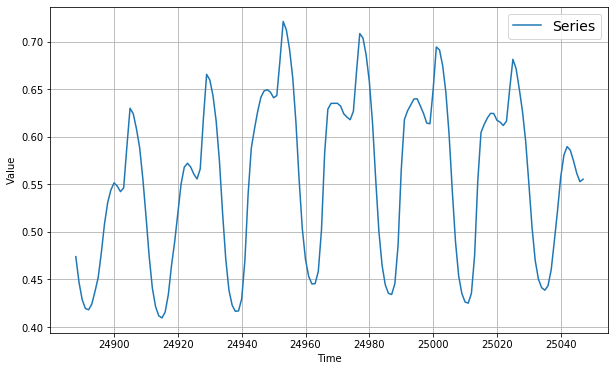

In [0]:
# Entire Series
split_time = len(train_series)
Series = series['load'].values
time = np.arange(len(series))

x_train = Series[:split_time]
x_valid = Series[split_time:]

time_valid = time[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid,start =0, end=160, label="Series")

In [0]:
# Forecating with machine learning

def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
# Linear Model
import time
start = time.time()
Keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = Keras.models.Sequential([
  Keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = Keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=Keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
model.fit(train_set, epochs=100, validation_data=valid_set)

end = time.time()

print("Time elapsed in min ", (end - start)/60)

Epoch 1/100
777/777 [==============================] - 9s 11ms/step - loss: 0.3247 - mape: 143.6280 - val_loss: 0.0000e+00 - val_mape: 0.0000e+00
Epoch 2/100
777/777 [==============================] - 5s 6ms/step - loss: 0.1208 - mape: 75.1323 - val_loss: 0.0635 - val_mape: 52.3863
Epoch 3/100
777/777 [==============================] - 5s 6ms/step - loss: 0.0482 - mape: 41.8999 - val_loss: 0.0322 - val_mape: 34.9978
Epoch 4/100
777/777 [==============================] - 5s 7ms/step - loss: 0.0278 - mape: 33.1645 - val_loss: 0.0232 - val_mape: 31.9953
Epoch 5/100
777/777 [==============================] - 5s 6ms/step - loss: 0.0218 - mape: 31.8025 - val_loss: 0.0206 - val_mape: 31.6758
Epoch 6/100
777/777 [==============================] - 5s 6ms/step - loss: 0.0200 - mape: 31.7380 - val_loss: 0.0197 - val_mape: 31.7325
Epoch 7/100
777/777 [==============================] - 4s 6ms/step - loss: 0.0194 - mape: 31.8102 - val_loss: 0.0193 - val_mape: 31.7869
Epoch 8/100
777/777 [===========

In [0]:
export_path_keras = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/neural_net_1")
print(export_path_keras)
model.save(export_path_keras)

/content/drive/My Drive/Colab Notebooks/Term_project_simulation/neural_net_1.h5


In [0]:
!ls

drive  neural_net_1.h5	sample_data


In [0]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers
export_path_keras = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/neural_net_1")
nn1 = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

nn1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 25        
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [0]:
window_size = 24
lin_forecast = model_forecast(nn1, Series[split_time - window_size:-1], window_size)[:, 0]

In [0]:
lin_forecast.shape

(8760,)

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start =0, end = 160)
plot_series(time_valid, lin_forecast, start = 0, end = 160)

In [0]:
# Linear model  epochs
start = time.time()
Keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = window_dataset(x_train, window_size)

model = Keras.models.Sequential([
  Keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = Keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = Keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=Keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

end = time.time()
print("Time elapsed in min ", (end - start)/60)

Epoch 1/100
777/777 [==============================] - 6s 7ms/step - loss: 0.0279 - mape: 39.9813
Epoch 2/100
777/777 [==============================] - 3s 4ms/step - loss: 0.0254 - mape: 37.8747
Epoch 3/100
777/777 [==============================] - 3s 4ms/step - loss: 0.0231 - mape: 35.8474
Epoch 4/100
777/777 [==============================] - 3s 4ms/step - loss: 0.0209 - mape: 33.9211
Epoch 5/100
777/777 [==============================] - 4s 5ms/step - loss: 0.0189 - mape: 32.1272
Epoch 6/100
777/777 [==============================] - 4s 5ms/step - loss: 0.0170 - mape: 30.4721
Epoch 7/100
777/777 [==============================] - 4s 5ms/step - loss: 0.0154 - mape: 28.9640
Epoch 8/100
777/777 [==============================] - 3s 4ms/step - loss: 0.0139 - mape: 27.5943
Epoch 9/100
777/777 [==============================] - 3s 4ms/step - loss: 0.0127 - mape: 26.3614
Epoch 10/100
777/777 [==============================] - 4s 5ms/step - loss: 0.0116 - mape: 25.2654
Epoch 11/100
777/77

[1e-06, 0.001, 0, 0.1]

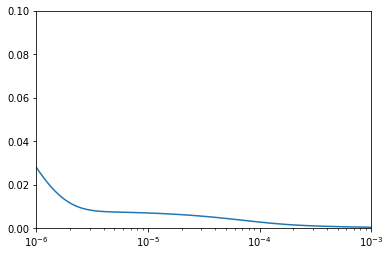

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 0.1])

In [0]:
start = time.time()
Keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = Keras.models.Sequential([
  Keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = Keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=Keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
early_stopping = Keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=1200,
          validation_data=valid_set,
          callbacks=[early_stopping])

end = time.time()
print("Time elapsed in min ", (end - start)/60)

export_path_keras = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/neural_net_2")
print(export_path_keras)
model.save(export_path_keras)


Epoch 1/1200
777/777 [==============================] - 8s 10ms/step - loss: 0.0201 - mape: 29.1439 - val_loss: 0.0000e+00 - val_mape: 0.0000e+00
Epoch 2/1200
777/777 [==============================] - 5s 7ms/step - loss: 0.0053 - mape: 15.8494 - val_loss: 0.0030 - val_mape: 12.6177
Epoch 3/1200
777/777 [==============================] - 5s 6ms/step - loss: 0.0024 - mape: 10.6578 - val_loss: 0.0016 - val_mape: 8.9624
Epoch 4/1200
777/777 [==============================] - 5s 6ms/step - loss: 0.0015 - mape: 8.1941 - val_loss: 0.0012 - val_mape: 7.3590
Epoch 5/1200
777/777 [==============================] - 5s 6ms/step - loss: 0.0012 - mape: 7.0785 - val_loss: 0.0010 - val_mape: 6.6649
Epoch 6/1200
777/777 [==============================] - 5s 6ms/step - loss: 0.0010 - mape: 6.5635 - val_loss: 9.1518e-04 - val_mape: 6.1810
Epoch 7/1200
777/777 [==============================] - 5s 6ms/step - loss: 9.6683e-04 - mape: 6.2815 - val_loss: 8.6965e-04 - val_mape: 6.0295
Epoch 8/1200
777/777 [=

In [0]:
export_path_keras = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/neural_net_2")
nn2 = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

nn2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 25        
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [0]:
lin_forecast = model_forecast(nn2, Series[split_time - window_size:-1], window_size)[:, 0]

In [0]:
lin_forecast.shape

(8760,)

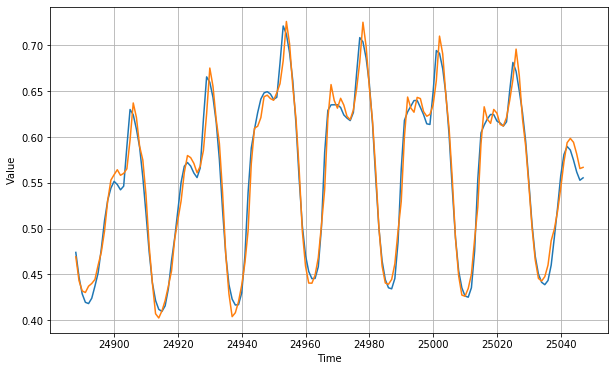

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start =0, end = 160)
plot_series(time_valid, lin_forecast, start = 0, end = 160)

In [0]:
Keras.metrics.mean_absolute_percentage_error(x_valid, lin_forecast).numpy()

1.8965489

In [0]:
# Dense Model Forecasting
start = time.time()
Keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = window_dataset(x_train, window_size)

model = Keras.models.Sequential([
  Keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  Keras.layers.Dense(10, activation="relu"),
  Keras.layers.Dense(1)
])

lr_schedule = Keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = Keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=Keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

end = time.time()
print("Time elapsed in min ", (end - start)/60)

Epoch 1/100
777/777 [==============================] - 6s 8ms/step - loss: 0.2830 - mape: 139.7060
Epoch 2/100
777/777 [==============================] - 3s 4ms/step - loss: 0.2788 - mape: 138.6488
Epoch 3/100
777/777 [==============================] - 4s 5ms/step - loss: 0.2742 - mape: 137.4737
Epoch 4/100
777/777 [==============================] - 3s 5ms/step - loss: 0.2691 - mape: 136.1677
Epoch 5/100
777/777 [==============================] - 3s 4ms/step - loss: 0.2635 - mape: 134.7178
Epoch 6/100
777/777 [==============================] - 4s 5ms/step - loss: 0.2574 - mape: 133.1107
Epoch 7/100
777/777 [==============================] - 4s 5ms/step - loss: 0.2507 - mape: 131.3298
Epoch 8/100
777/777 [==============================] - 4s 5ms/step - loss: 0.2433 - mape: 129.3600
Epoch 9/100
777/777 [==============================] - 3s 4ms/step - loss: 0.2354 - mape: 127.1870
Epoch 10/100
777/777 [==============================] - 4s 5ms/step - loss: 0.2268 - mape: 124.7923
Epoch 11/

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 0.3])

[1e-07, 0.005, 0, 0.3]

In [0]:
# Dense model improved
import time
start = time.time()
Keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = Keras.models.Sequential([
  Keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  Keras.layers.Dense(10, activation="relu"),
  Keras.layers.Dense(1)
])

optimizer = Keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=Keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
early_stopping = Keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=1200,
          validation_data=valid_set,
          callbacks=[early_stopping])
end = time.time()
print("Time elapsed in min ", (end - start)/60)

export_path_keras = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/neural_net_3")
print(export_path_keras)
model.save(export_path_keras)

Epoch 1/1200
777/777 [==============================] - 8s 10ms/step - loss: 0.0043 - mape: 14.4381 - val_loss: 0.0000e+00 - val_mape: 0.0000e+00
Epoch 2/1200
777/777 [==============================] - 5s 6ms/step - loss: 0.0024 - mape: 11.2488 - val_loss: 0.0019 - val_mape: 10.0383
Epoch 3/1200
777/777 [==============================] - 5s 6ms/step - loss: 0.0017 - mape: 9.2673 - val_loss: 0.0013 - val_mape: 8.2872
Epoch 4/1200
777/777 [==============================] - 4s 6ms/step - loss: 0.0011 - mape: 7.6755 - val_loss: 9.0666e-04 - val_mape: 6.8876
Epoch 5/1200
777/777 [==============================] - 5s 6ms/step - loss: 8.3539e-04 - mape: 6.5126 - val_loss: 6.9416e-04 - val_mape: 5.9680
Epoch 6/1200
777/777 [==============================] - 5s 6ms/step - loss: 6.6565e-04 - mape: 5.7206 - val_loss: 5.7847e-04 - val_mape: 5.3604
Epoch 7/1200
777/777 [==============================] - 5s 6ms/step - loss: 5.7117e-04 - mape: 5.2060 - val_loss: 5.1058e-04 - val_mape: 4.8989
Epoch 8/

NameError: ignored

In [0]:
dense_forecast = model_forecast(
    model,
    Series[split_time - window_size:-1],
    window_size)[:, 0]

In [0]:
export_path_keras = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/neural_net_3")
print(export_path_keras)
model.save(export_path_keras)

/content/drive/My Drive/Colab Notebooks/Term_project_simulation/neural_net_3.h5


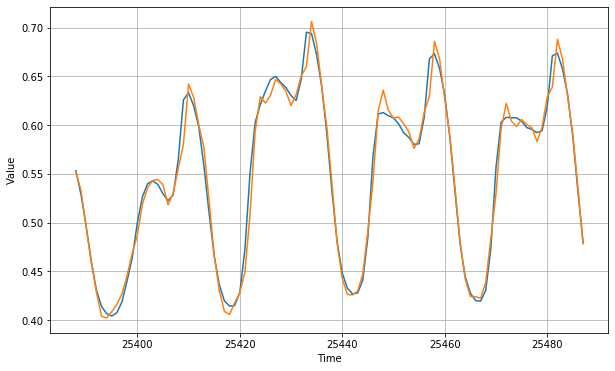

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=500, end=600)
plot_series(time_valid, dense_forecast, start =500, end = 600)

In [0]:
Keras.metrics.mean_absolute_percentage_error(x_valid, dense_forecast).numpy()

1.4460201

In [0]:
model.loss?